## <font color='#EE7600'> UNIVERSIDADE DO VALE DO RIO DOS SINOS - UNISINOS
<font color='#FFA500'> CURSO DE ESPECIALIZAÇÃO PÓS-GRADUAÇÃO EM BIG DATA, DATA SCIENCE E DATA ANALYTICS

<font color='#696969'> **Amanda Ely Patzer**<br>
<font color='#696969'> **James Augusto Lima La Rosa**<br>
<font color='#696969'> **Róger William Calderini**<br>
<font color='#696969'> **Vinícius D`Ambros**<br>
<font color='#696969'> **Viviana Terceros Cordova**<br>      
<br>


### SISTEMA DE RECOMENDAÇÃO PARA A BIBLIOTECA MUNDIAL - "BOOKCROSSING" - https://www.bookcrossing.com/
<br>
<br>
    
#### Prof. Gabriel de Oliveira Ramos<br>
#### Deep Learning<br>

São Leopoldo, julho 2020
<br>  
<br>  

### **1	INTRODUÇÃO**

Os sistemas de recomendação (RecSys) são dependentes de muitas motivações, arquiteturas e alguns códigos, e por que utilizar Aprendizado Profundo (Deep Learning). Um ***RecSys*** tem com principal objetivo selecionar o conteúdo que será entregue ao usuário de determinada plataforma. Como já conhecemos estão presentes em diferentes domínios, notícias, filmes, músicas, livros etc.   

Esse ambiente trata dois personagens o "usuário" x "contéudo". Com isso melhoramos a experiência do usuário com a plataforma e melhoramos os negócios oferecidos. São alguns segundos para apresentar algo ótimo, somente uma pequena lista, que irá impactar, e assim essa aceitação afeta diretamente a satisfação do usuário.  
<br>  

#### **1.1 RecSys como problema de aprendizagem**

Os (RecSys) são abordados e tratados comumentes como problemas de Aprendizado de Máquina (Machine Learning), e sim, também muito abordados atualmente com Aprendizado Profundo (Deep Learning).  
<br>  

>   #### ***O sistema deve aprender como nosso usuário consome, prever e apresentar sugestões dentro da plataforma.***  

<br>  

Para realizarmos esta solução, existem algumas formas de abordar este problema com alguns métodos e algoritmos diferentes. Em nosso trabalho, iremos abordar um dos métodos amplamente utilizados a ***"Filtragem Colaborativa - (Collaborative Filter)"***. Através deste método, ignoramos as características de conteúdo e aboirdados a relação Usuário x Conteúdo, possibilitando assim trocar recomendações entre usuários semelhantes. Com isso, precisamos identificar a força dessa interação, avaliando o comportamento desse usuário com o conteúdo em si, geralemnte modelando um score para nos ajudar.

### **2	O PROBLEMA**

A comunidade ***BOOKCROSSING*** é uma "**Biblioteca Mundial**". Uma rede social inteligente e ativa, existente atualmente em 132 países, com **1.897.903 *BookCrossers*** e mais de **13 milhões de livros** viajando. Eles visam conectar as pessoas através de livros. Seus participantes etiquetam, liberam e seguem os seus livros. Eles possuem um sistema que, ao se associar, a pessoa doa um livro, cria uma etiqueta com código único, e envia esse livro para um outro leitor interessado. Ao invés de você guardar seu livro na estante após lê-lo, você passa para outras pessoas ao redor do mundo, e pode rastreá-los através da plataforma. Assim, é criada uma grande plataforma de troca de livros, conectando os mais váriados gêneros da literatura. Para conectá-los de forma assertiva, é necessário um sistema de recomendação mais eficiente. Como a plataforma já possui um sistema que permite a geração de notas sobre cada título lido, solicitou um RECSYS:  
  
> #### Criar um sistema de recomendação para os usuários da plataforma baseados em seu sistema de score.  

<br>  
  
### **3 OBJETIVO**

  1.  Criar um protótipo de Sistema de Recomendação (RecSys) baseado em seu sistemas de *score* somente com os usuários do Estados Unidos da América<br>
  2.  Descreve e realizar experimentos com algoritmos de aprendizagem de máquina e aprendizagem profunda;<br>
  3.  Descrever e testar as possibilidades de recomendação atingidas.<br>  


### **4. IMPORTAÇÃO DAS BIBLIOTECAS**

Upload das bibliotecas que serão utilizadas inicialmente.

In [2]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential
from keras.datasets import mnist

#Visualização
import seaborn as sns
sns.set(style='white', context='notebook', palette='pastel')
#Visualização dos dados
import matplotlib.pyplot as plt

#Used for distribution fitting, and representation
from scipy import stats

#Time measuring for model training
from time import time

#dependência do matplotlib
!pip install msgpack 
#instalação do pacote matplotlib
!pip install matplotlib  
import matplotlib.pyplot as plt 
import pandas as pd  
import statsmodels.api as sm  
import pylab as pl  
import numpy as np  
from patsy import dmatrix  

!pip install wordcloud
from os import path
from PIL import Image

import sklearn as sk
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **5. UPLOAD DA BASE**

Ao analisarmos a base de dados por completo e executar uma técnica de machine learning, o código *crashed* devido ao excesso de dados. Por isso, para compararmos qual método é mais eficaz, aplicou-se o corte de país USA e considerando apenas as avaliações explícitas (1-10), removendo registros com 0. A opção por considerar somente avaliações explícitas se deve ao fato de que registros com rating 0 não significam, necessariamente, insatisfação do usuário com o conteúdo, dado que conteúdos não avaliados também ficam registrados como “0”.

In [3]:
import pandas as pd  
url_book_rating = 'https://raw.githubusercontent.com/vivitc/deep-learning-books/master/data/BX-Book-Ratings01.csv'
df_book_rating = pd.read_csv(url_book_rating, delimiter=";", encoding="latin1")

In [4]:
display(df_book_rating)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [5]:
import pandas as pd  
url_book = 'https://raw.githubusercontent.com/vivitc/deep-learning-books/master/data/BX-Books01.csv'
df_book = pd.read_csv(url_book, delimiter=";", encoding="latin1")

In [6]:
display(df_book)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271374,440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271375,525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271376,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271377,192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


In [7]:
import pandas as pd  
url_users = 'https://raw.githubusercontent.com/vivitc/deep-learning-books/master/data/BX-Users01.csv'
df_users = pd.read_csv(url_users, delimiter=";", encoding="latin1", header=0)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
display(df_users)

,User-ID,Location_CT,Location_UF,Location_CY,Age
0,120567,545,rheinland-pfalz,germany,NaN
1,84244,01109,sachsen,germany,40.0
2,151969,1700,fribourg,switzerland,24.0
3,147786,01721,NaN,NaN,37.0
4,160922,3003,tenerife,espaã±a,30.0
...,...,...,...,...,...
277660,258249,zwolle,NaN,netherlands,26.0
277661,239223,zxcvzxcvzxcvz,abruzzo,italy,32.0
277662,146905,zywiec,slaskie,poland,22.0
277663,51181,new york city,new york,usa,NaN


### **6. ANÁLISE DESCRITIVA DOS DADOS**
Em seguida, vamos fazer alguns pré-processamentos básicos para conhecer os dados, lembrando os códigos:
- **BX-Users**: Contém os usuários(`User-ID`) anônimos. Dados demográficos organizados, quando disponíveis (`Location`, `Age`). `Age` com valor NaN, significa que o valor de `Age` nao foi disponibilizado.

- **BX-Books**: Os livros são identificados pelo ISBN (os inválidos já foram removidos). Informações sobre conteúdo são disponíveis como (`Book-Title`, `Book-Author`, `Year-Of-Publication`, `Publisher`), pelo Amazon Web Services. Se houver mais de 1 autor, só o primeiro é mencionado. Imagens da capa estão disponíveis em pequeno, médio e grande (`Image-URL-S`, `Image-URL-M`, `Image-URL-L`), pelo Amazon Web Services também.

- **BX-Book-Ratings**: As avaliações dos livros (`Book-Rating`)  são ou explícitas de 1-10 (valores mais altos indicam mais apreciação), ou implicito, expresso por 0.

Como informado anteriormente, apesar da base ter diversos países e avaliações, testamos a análise descritiva dos dados e a Filtragem Colaborativa com os dados completos e recebemos uma mensagem de erro devido ao tamanho da Matriz de Interação:

    *Erro: ValueError: Unstacked DataFrame is too big, causing int32 overflow*

Assim, foram feitos alguns recortes na base para que seja possível trabalhá-la, sendo:
- Utilização dos dados referente ao Country USA;
- Utilização de livros com avaliações explícitas, ou seja, Ratings de 1-10.

#### **6.1 LIMPEZA DA BASE**
Para melhorar o desempenho, foi realizada uma adequação na estrutura original dos Users, conforme explica o esquema a seguir. O trabalho de organização dos dados foi focado principalmente no campo Location, que possuia dados de cidade, região/estado e país juntos. Assim, foram criados 3 campos com estes conjuntos, além de um trabalho  de adequação de escrita, para o inglês, assim como a uniformização de escrita das cidades, assim como a grafia das abreviações, sendo utilizadas funções recorrentes e tabelas dinâmicas. Sem esta adequação, as análises e modelos seriam ineficazes, pois a base estava suja.

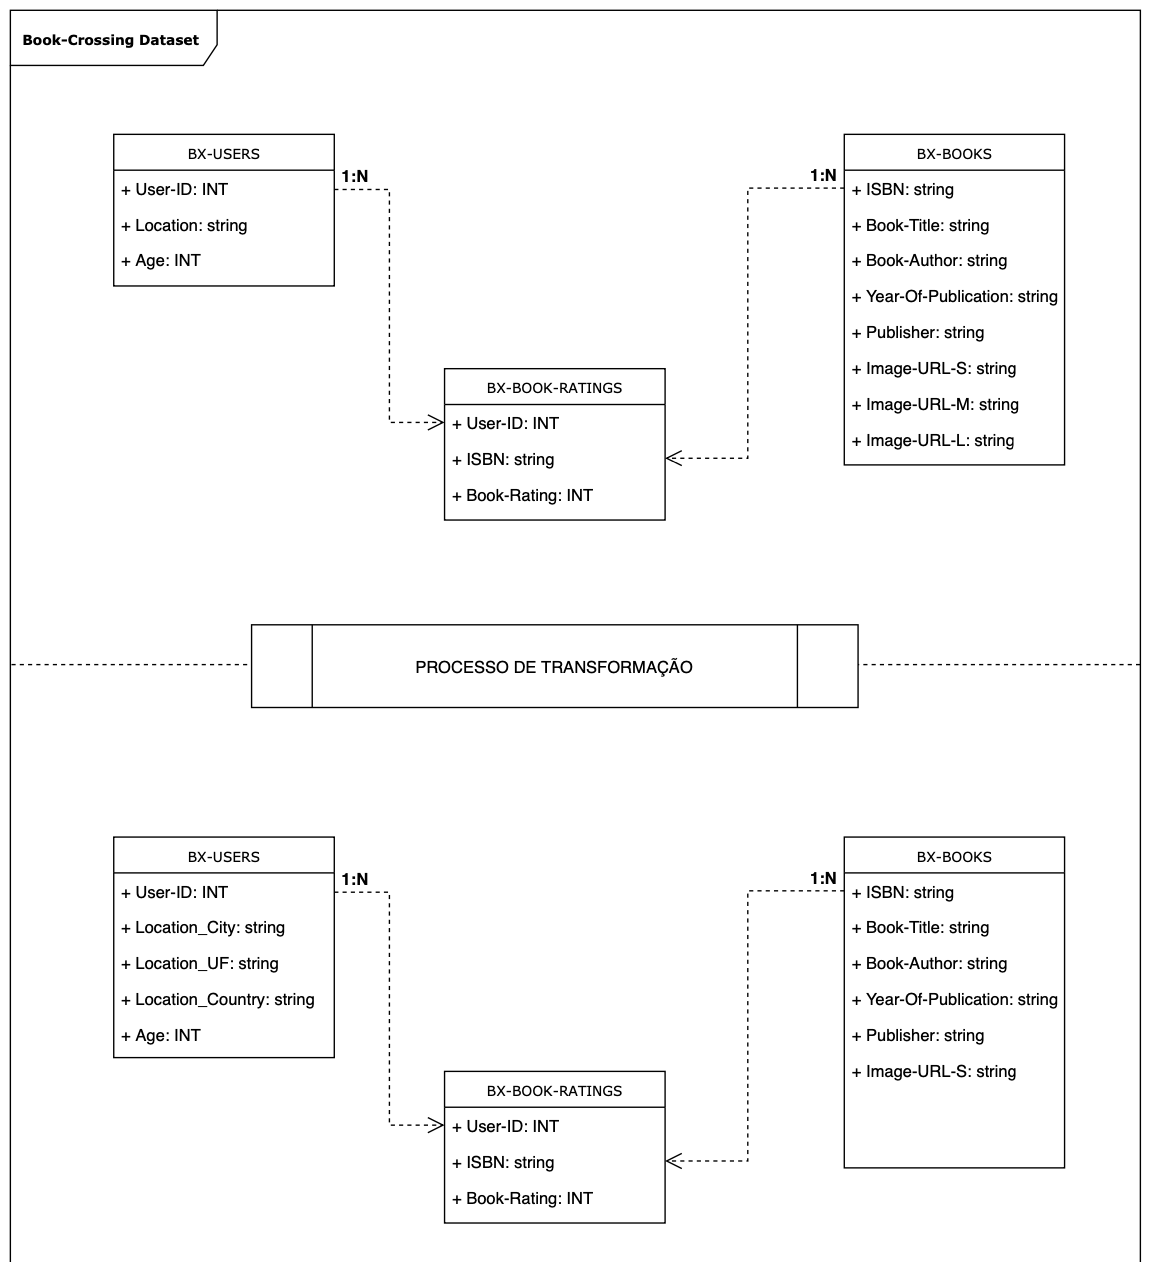

#### **6.2 NORMALIZAÇÃO DE DADOS**

In [9]:
#Normalizacao de Location para poder fazer comparação. Removendo espaços em branco

df_users['Location_CY'] = df_users['Location_CY'].str.strip()
df_users

,User-ID,Location_CT,Location_UF,Location_CY,Age
0,120567,545,rheinland-pfalz,germany,NaN
1,84244,01109,sachsen,germany,40.0
2,151969,1700,fribourg,switzerland,24.0
3,147786,01721,NaN,NaN,37.0
4,160922,3003,tenerife,espaã±a,30.0
...,...,...,...,...,...
277660,258249,zwolle,NaN,netherlands,26.0
277661,239223,zxcvzxcvzxcvz,abruzzo,italy,32.0
277662,146905,zywiec,slaskie,poland,22.0
277663,51181,new york city,new york,usa,NaN


In [10]:
# Procurando os usuário que são do país USA
import numpy as np
df_users_usa = df_users[(df_users['Location_CY'] == "usa")]
df_users_usa

,User-ID,Location_CT,Location_UF,Location_CY,Age
8,266829,alburg,vermont,usa,NaN
13,155407,new york city,new york,usa,NaN
14,198308,bronx,new york,usa,46.0
19,130531,vicksburg,mississippi,usa,25.0
20,183556,covington,kentucky,usa,NaN
...,...,...,...,...,...
277320,258411,zumbrota,minnesota,usa,NaN
277321,276509,zumbrota,minnesota,usa,NaN
277324,142979,zuni,virginia,usa,56.0
277325,143351,zuni,new mexico,usa,NaN


In [11]:
# Considerando apenas book rating com avaliação explícita, ou seja, rating superior a 0
df_book_with_explicit_rating = df_book_rating[(df_book_rating['Book-Rating'] > 0)]
df_book_with_explicit_rating

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6
...,...,...,...
1149773,276704,0806917695,5
1149775,276704,1563526298,9
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [12]:
# Relacionando os usuários de USA e as avaliações que fizeram

merged_user_book_rating_df = pd.merge(left=df_users_usa, right=df_book_with_explicit_rating, left_on='User-ID', right_on='User-ID')
merged_user_book_rating_df

,User-ID,Location_CT,Location_UF,Location_CY,Age,ISBN,Book-Rating
0,141273,lockport,illinois,usa,39.0,0671020641,4
1,147387,lockport,illinois,usa,41.0,0060160594,8
2,239476,lockport,illinois,usa,41.0,0425054713,10
3,278251,lockport,new york,usa,45.0,044020562X,7
4,98037,locust,north carolina,usa,33.0,0142004235,8
...,...,...,...,...,...,...,...
141976,199717,zion grove,pennsylvania,usa,24.0,0441569595,5
141977,220014,zionsville,indiana,usa,NaN,0312924585,8
141978,220014,zionsville,indiana,usa,NaN,0679742298,8
141979,11374,zionville,north carolina,usa,48.0,0671702513,4


In [13]:
# quantidade de usuarios únicos que avaliaram algum livro de forma explícita
users_who_evaluated = merged_user_book_rating_df['User-ID'].nunique()
users_who_evaluated

23934

In [14]:
# quantidade de livros avaliados de forma explícita
books_evaluated = merged_user_book_rating_df['ISBN'].nunique()
books_evaluated

70525

#### **6.3 ANÁLISE DE USERS**

In [15]:
#Verificando as estatísticas básicas
df_users_usa.describe

<bound method NDFrame.describe of        User-ID    Location_CT  Location_UF Location_CY   Age
8       266829         alburg      vermont         usa   NaN
13      155407  new york city     new york         usa   NaN
14      198308          bronx     new york         usa  46.0
19      130531      vicksburg  mississippi         usa  25.0
20      183556      covington     kentucky         usa   NaN
...        ...            ...          ...         ...   ...
277320  258411       zumbrota    minnesota         usa   NaN
277321  276509       zumbrota    minnesota         usa   NaN
277324  142979           zuni     virginia         usa  56.0
277325  143351           zuni   new mexico         usa   NaN
277663   51181  new york city     new york         usa   NaN

[140181 rows x 5 columns]>

In [16]:
#Entendendo se temos muitos valores faltantes
df_users_usa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140181 entries, 8 to 277663
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   User-ID      140181 non-null  object 
 1   Location_CT  140118 non-null  object 
 2   Location_UF  140181 non-null  object 
 3   Location_CY  140181 non-null  object 
 4   Age          76693 non-null   float64
dtypes: float64(1), object(4)
memory usage: 6.4+ MB


In [17]:
# Quantitade de dados faltantes por feature de usuario

total = df_users_usa.isnull().sum().sort_values(ascending = False)
percent = (df_users_usa.isnull().sum()/df_users_usa.isnull().count()*100).sort_values(ascending = False)
missing_df_users_usa  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_df_users_usa

,Total,Percent
Age,63488,45.290018
Location_CT,63,0.044942
Location_CY,0,0.000000
Location_UF,0,0.000000
User-ID,0,0.000000


california        19646
texas              8356
new york           8308
florida            6928
washington         6292
pennsylvania       6025
illinois           5865
ohio               4643
michigan           4575
oregon             4304
virginia           4282
massachusetts      3961
missouri           3937
north carolina     3714
new jersey         3584
georgia            3303
minnesota          3087
colorado           2563
wisconsin          2559
maryland           2544
Name: Location_UF, dtype: int64

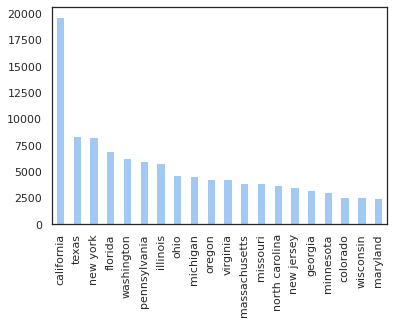

In [18]:
# UF dos usuários e a quantidade de usuarios que dizem morar em eles
Users_USA_UF=df_users_usa["Location_UF"].value_counts(ascending=False)
Users_USA_UF.head(20).plot.bar()
Users_USA_UF.head(20)

34.0    2199
35.0    1988
33.0    1987
29.0    1935
32.0    1931
36.0    1854
24.0    1845
28.0    1845
31.0    1828
30.0    1823
26.0    1797
25.0    1794
27.0    1783
37.0    1693
23.0    1677
38.0    1651
39.0    1606
40.0    1567
41.0    1567
43.0    1550
Name: Age, dtype: int64

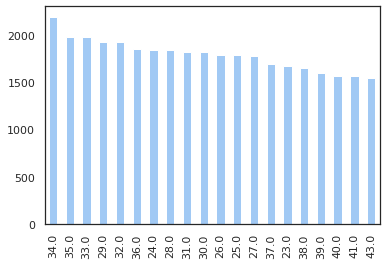

In [19]:
# Idade dos usuários - considerando so usuario de USA
Users_USA_Age=df_users_usa["Age"].value_counts(ascending=False)
Users_USA_Age.head(20).plot.bar()
Users_USA_Age.head(20)

[(0.0, 0.035), (1.0, 100.0)]

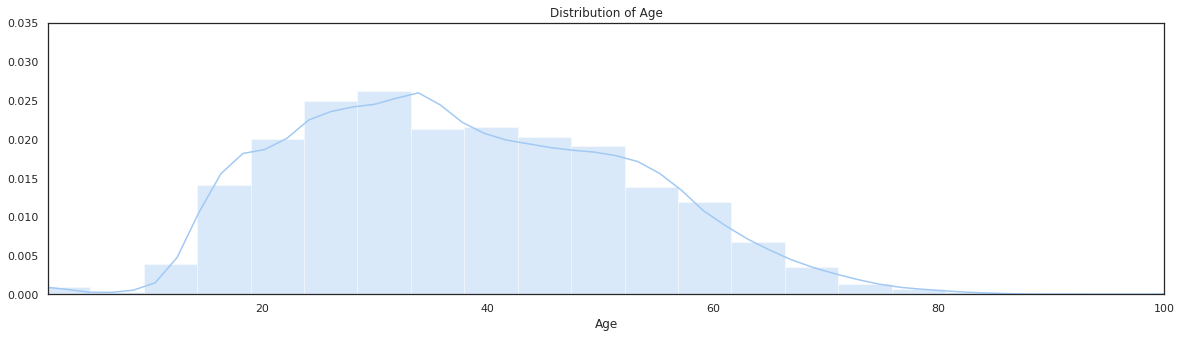

In [20]:
#Histograma com distribuição de idade

plt.figure(figsize=(20,5))
plt.title("Distribution of Age")
ax = sns.distplot(df_users_usa["Age"])
ax.set(xlim=(1, 100), ylim=(0, 0.035))

#### **6.4 ANÁLISE DE BOOKS**

In [21]:
df_book_complete_info = df_book.merge(df_book_with_explicit_rating['ISBN'])
df_book_complete_info.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...
1,1552041778,Jane Doe,R. J. Kaiser,1999,Mira Books,http://images.amazon.com/images/P/1552041778.0...,http://images.amazon.com/images/P/1552041778.0...,http://images.amazon.com/images/P/1552041778.0...
2,1558746218,A Second Chicken Soup for the Woman's Soul (Ch...,Jack Canfield,1998,Health Communications,http://images.amazon.com/images/P/1558746218.0...,http://images.amazon.com/images/P/1558746218.0...,http://images.amazon.com/images/P/1558746218.0...
3,1558746218,A Second Chicken Soup for the Woman's Soul (Ch...,Jack Canfield,1998,Health Communications,http://images.amazon.com/images/P/1558746218.0...,http://images.amazon.com/images/P/1558746218.0...,http://images.amazon.com/images/P/1558746218.0...
4,1558746218,A Second Chicken Soup for the Woman's Soul (Ch...,Jack Canfield,1998,Health Communications,http://images.amazon.com/images/P/1558746218.0...,http://images.amazon.com/images/P/1558746218.0...,http://images.amazon.com/images/P/1558746218.0...


In [22]:
df_book_complete_info.shape

(80806, 8)

In [23]:
#Verificando as estatísticas básicas
df_book_complete_info.describe(exclude=[np.object])

,Year-Of-Publication
count,80806.000000
mean,1938.969136
std,335.578786
min,0.000000
25%,1994.000000
50%,1999.000000
75%,2001.000000
max,2037.000000


In [24]:
#Entendendo se temos muitos valores faltantes
df_book_complete_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80806 entries, 0 to 80805
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ISBN                 80806 non-null  object
 1   Book-Title           80806 non-null  object
 2   Book-Author          80805 non-null  object
 3   Year-Of-Publication  80806 non-null  int64 
 4   Publisher            80804 non-null  object
 5   Image-URL-S          80806 non-null  object
 6   Image-URL-M          80806 non-null  object
 7   Image-URL-L          80806 non-null  object
dtypes: int64(1), object(7)
memory usage: 5.5+ MB


2002    8958
2001    8141
2003    7612
1999    7387
2000    6781
1998    5627
1997    5291
1996    4427
1995    4174
1994    2998
1992    2564
1993    2471
0       2349
2004    1759
1991    1648
1990    1203
1989    1028
1988     850
1987     652
1985     542
Name: Year-Of-Publication, dtype: int64

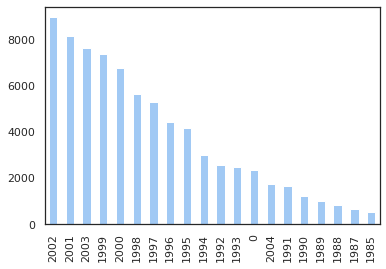

In [25]:
# Anos de publicação Top 20
Ratings=df_book_complete_info["Year-Of-Publication"].value_counts(ascending=False)
Ratings.head(20).plot.bar()
Ratings.head(20)



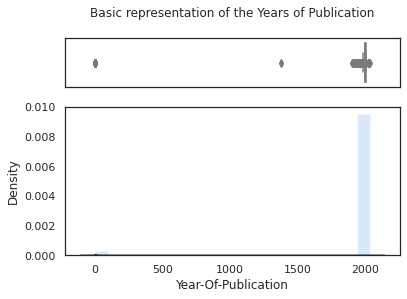

In [26]:
#Histograma de pontos com toda base

#Subplot grid
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.25, 0.75)})
 
#Plot + subplot grid
sns.boxplot(df_book_complete_info["Year-Of-Publication"], ax=ax_box).set_title("Basic representation of the Years of Publication\n")
sns.distplot(df_book_complete_info["Year-Of-Publication"], ax=ax_hist, kde=False, fit=stats.gamma, bins=20)
sns.set_color_codes("bright")

#Legendas
ax_box.set(xlabel='') #Remove x axis name for the boxplot
ax_hist.set(ylabel='Density')

plt.show()

In [27]:
Q3 = np.quantile(df_book_complete_info["Year-Of-Publication"], 0.75) #Third quartile
Q1 = np.quantile(df_book_complete_info["Year-Of-Publication"], 0.25) #First quartile
IQR = Q3 - Q1 #Inter Quartile Range
sns.set_color_codes("bright")

outlier_score_threshold =  Q3 + 1.5 * IQR
outlier_number=len(df_book_complete_info[df_book_complete_info["Year-Of-Publication"] > outlier_score_threshold ])

print("Number of outliers:", outlier_number,
      "\nOutlier proportion:", round(outlier_number/len(merged_user_book_rating_df["Book-Rating"])*100, 3),"%",
      "\nOutlier threshold score:", outlier_score_threshold,"/ 100")

Number of outliers: 7 
Outlier proportion: 0.005 % 
Outlier threshold score: 2011.5 / 100


[(0.0, 0.05), (1940.0, 2050.0)]

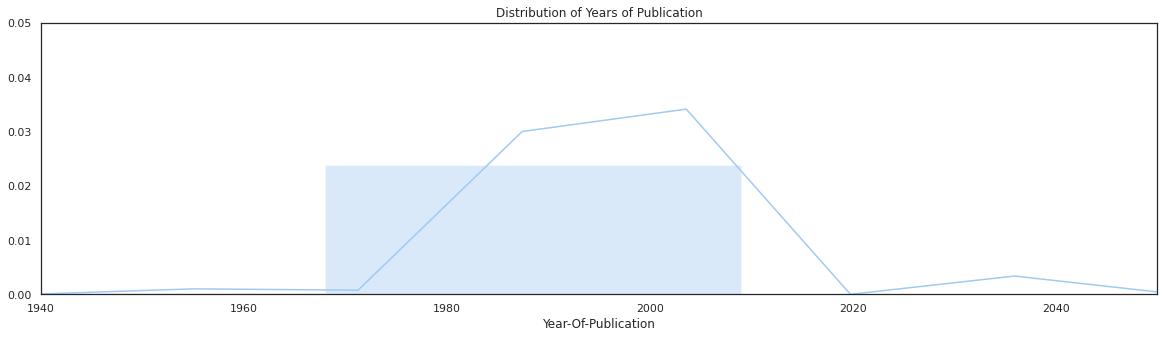

In [28]:
#Histograma com distribuição dos anos de publicação
plt.figure(figsize=(20,5))
plt.title("Distribution of Years of Publication")
ax = sns.distplot(df_book["Year-Of-Publication"])
ax.set(xlim=(1940, 2050), ylim=(0, 0.05))


#### **6.5 ANÁLISE DE BOOKS RATINGS**

In [29]:
#Verificando as estatísticas básicas
df_book_rating = merged_user_book_rating_df[['User-ID', 'ISBN', 'Book-Rating']]
df_book_rating.describe

<bound method NDFrame.describe of        User-ID        ISBN  Book-Rating
0       141273  0671020641            4
1       147387  0060160594            8
2       239476  0425054713           10
3       278251  044020562X            7
4        98037  0142004235            8
...        ...         ...          ...
141976  199717  0441569595            5
141977  220014  0312924585            8
141978  220014  0679742298            8
141979   11374  0671702513            4
141980  242766  1572232684           10

[141981 rows x 3 columns]>

In [30]:
#Entendendo se temos muitos valores faltantes
df_book_rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141981 entries, 0 to 141980
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      141981 non-null  object
 1   ISBN         141981 non-null  object
 2   Book-Rating  141981 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.3+ MB


In [31]:
total = df_book_rating.isnull().sum().sort_values(ascending = False)
percent = (df_book_rating.isnull().sum()/df_book_rating.isnull().count()*100).sort_values(ascending = False)
missing_df_book_rating  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_df_book_rating

,Total,Percent
Book-Rating,0,0.0
ISBN,0,0.0
User-ID,0,0.0


8     33462
10    28571
9     23391
7     22563
5     17324
6     10913
4      2648
3      1751
2       826
1       532
Name: Book-Rating, dtype: int64

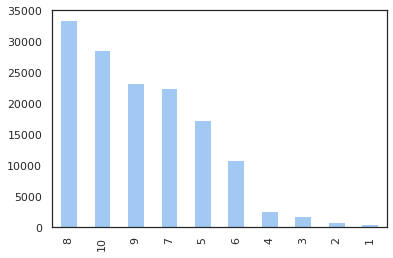

In [32]:
# Ratings de 1 a 10
Ratings=df_book_rating["Book-Rating"].value_counts(ascending=False)
Ratings.head(10).plot.bar()
Ratings.head(10)



In [33]:
total = df_book_rating["Book-Rating"].value_counts(ascending=False)
percent = (df_book_rating.count()/df_book_rating.count()*100).sort_values(ascending = False)
Ratings_percent  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
Ratings_percent

,Total,Percent
1,532.0,NaN
2,826.0,NaN
3,1751.0,NaN
4,2648.0,NaN
5,17324.0,NaN
6,10913.0,NaN
7,22563.0,NaN
8,33462.0,NaN
9,23391.0,NaN
10,28571.0,NaN


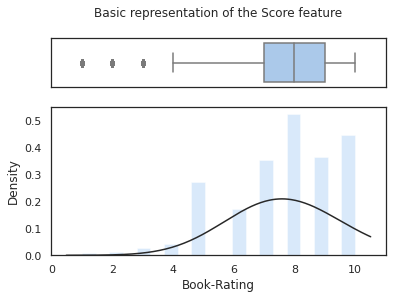

In [34]:
#Histograma de pontos com toda base

#Subplot grid
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.25, 0.75)})
 
#Plot + subplot grid
sns.boxplot(df_book_rating["Book-Rating"], ax=ax_box).set_title("Basic representation of the Score feature\n")
sns.distplot(df_book_rating["Book-Rating"], ax=ax_hist, kde=False, fit=stats.gamma, bins=20)
sns.set_color_codes("bright")

#Legendas
ax_box.set(xlabel='') #Remove x axis name for the boxplot
ax_hist.set(ylabel='Density')

plt.show()

In [35]:
Q3 = np.quantile(df_book_rating["Book-Rating"], 0.75) #Third quartile
Q1 = np.quantile(df_book_rating["Book-Rating"], 0.25) #First quartile
IQR = Q3 - Q1 #Inter Quartile Range
sns.set_color_codes("bright")

outlier_score_threshold =  Q3 + 1.5 * IQR
outlier_number=len(df_book_rating[ df_book_rating["Book-Rating"] > outlier_score_threshold ])

print("Number of outliers:", outlier_number,
      "\nOutlier proportion:", round(outlier_number/len(df_book_rating["Book-Rating"])*100, 3),"%",
      "\nOutlier threshold score:", outlier_score_threshold,"/ 100")

Number of outliers: 0 
Outlier proportion: 0.0 % 
Outlier threshold score: 12.0 / 100


[(0.0, 3.5), (-1.0, 11.0)]

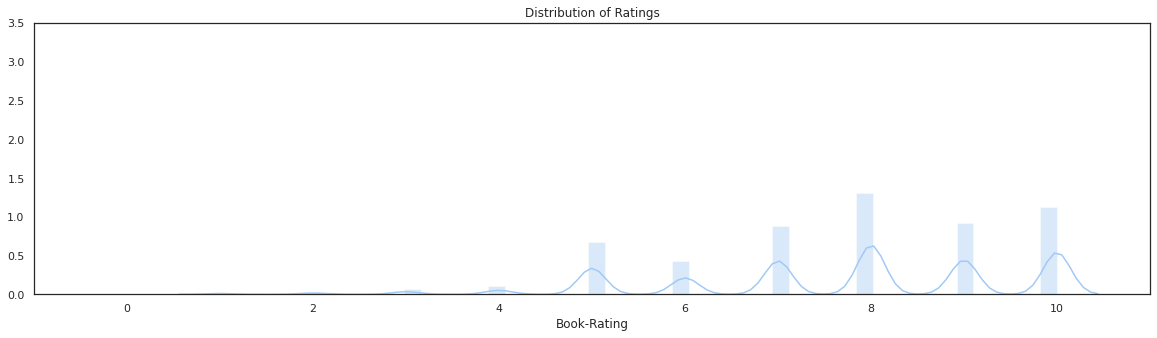

In [36]:
#Histograma com distribuição dos Ratings
plt.figure(figsize=(20,5))
plt.title("Distribution of Ratings")
ax = sns.distplot(df_book_rating["Book-Rating"])
ax.set(xlim=(-1, 11), ylim=(0, 3.5))

### **7. DESENVOLVIMENTO DAS TÉCNICAS**
Executaremos a filtragem com DL e sem DL, para depois compararmos as seguintes métricas:

**Qualidade de predição**

•	[Mean Absolute Error (MAE)](https://keras.io/api/metrics/regression_metrics/#meanabsoluteerror-class): calcula o desvio absoluto médio entre as predições do sistema de recomendação e as avaliações reais feitas pelos alunos, e a diferença obtida é tomada como o erro da predição. Possibilita verificar o impacto da utilização das recomendações feitas pelo sistema no que se refere à margem de erro das recomendações calculadas.

•	[Root Mean Square Error (RMSE)](https://keras.io/api/metrics/regression_metrics/#rootmeansquarederror-class): é semelhante à métrica MAE no sentido em que mede o erro do modelo. No entanto, a maior diferença com relação ao MAE é que ela penaliza os erros grandes em comparação aos pequenos.

**Conjunto de recomendações**

•	[Precisão(P)](https://keras.io/api/metrics/classification_metrics/#auc-class) – relação entre o número de conteúdos que o usuário considera relevante e o número de conteúdos recomendados.

As métricas foram selecionadas tendo como base levantamento feito com artigos científicos sobre sistemas de recomendação, em que MAE, RMSE e Precision tiveram maior incidência.


#### **7.1 - Filtragem Colaborativa com Deep Learning**

#### Utilizando a biblioteca Keras

In [36]:
#https://medium.com/@jdwittenauer/deep-learning-with-keras-recommender-systems-e7b99cb29929
import sklearn as sk
from sklearn.preprocessing import LabelEncoder

user_enc = LabelEncoder()
merged_user_book_rating_df['userUniq'] = user_enc.fit_transform(merged_user_book_rating_df['User-ID'].values)
n_users = merged_user_book_rating_df['userUniq'].nunique()

book_enc = LabelEncoder()
merged_user_book_rating_df['bookUniq'] = book_enc.fit_transform(merged_user_book_rating_df['ISBN'].values)
n_books = merged_user_book_rating_df['bookUniq'].nunique()

merged_user_book_rating_df['Book-Rating'] = merged_user_book_rating_df['Book-Rating'].values.astype(np.float32)
min_rating = min(merged_user_book_rating_df['Book-Rating'])
max_rating = max(merged_user_book_rating_df['Book-Rating'])

n_users, n_books, min_rating, max_rating

(23934, 70525, 1.0, 10.0)

In [37]:
from sklearn.model_selection import train_test_split

X = merged_user_book_rating_df[['userUniq', 'bookUniq']].values
y = merged_user_book_rating_df['Book-Rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((127782, 2), (14199, 2), (127782,), (14199,))

In [38]:
n_factors = 40
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [39]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot, Add, Activation, Lambda
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers.embeddings import Embedding
from tensorflow.keras.metrics import RootMeanSquaredError

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

def Recommender(n_users, n_books, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    
    book = Input(shape=(1,))
    m = EmbeddingLayer(n_books, n_factors)(book)
    mb = EmbeddingLayer(n_books, 1)(book)
    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, book], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy', 'mae', RootMeanSquaredError()])
    return model

In [40]:
model = Recommender(n_users, n_books, n_factors, min_rating, max_rating)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 40)        957360      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 40)        2821000     input_2[0][0]                    
____________________________________________________________________________________________

In [41]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 127782 samples, validate on 14199 samples
Epoch 1/5
127782/127782 [==============================] - 123s 966us/step - loss: 6.8255 - accuracy: 0.1068 - mae: 2.2502 - root_mean_squared_error: 2.7362 - val_loss: 5.6002 - val_accuracy: 0.1201 - val_mae: 2.0122 - val_root_mean_squared_error: 2.5999
Epoch 2/5
127782/127782 [==============================] - 122s 955us/step - loss: 4.3340 - accuracy: 0.1864 - mae: 1.7029 - root_mean_squared_error: 2.4693 - val_loss: 4.4540 - val_accuracy: 0.1629 - val_mae: 1.7452 - val_root_mean_squared_error: 2.3553
Epoch 3/5
127782/127782 [==============================] - 122s 957us/step - loss: 2.4086 - accuracy: 0.3426 - mae: 1.1652 - root_mean_squared_error: 2.2332 - val_loss: 4.0912 - val_accuracy: 0.1744 - val_mae: 1.6537 - val_root_mean_squared_error: 2.1308
Epoch 4/5
127782/127782 [==============================] - 123s 964us/step - loss: 1.3582 - accuracy: 0.4937 - mae: 0.8067 - root_mean_squared_error: 2.0328 - val_loss: 3.9743 - val_ac

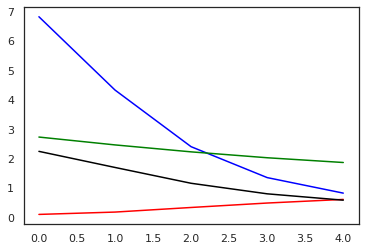

In [42]:
#https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/
from matplotlib import pyplot

# plot metrics
pyplot.plot(history.history['loss'], color='blue') # mean_squared_error
pyplot.plot(history.history['root_mean_squared_error'], color='green')
pyplot.plot(history.history['accuracy'], color='red')
pyplot.plot(history.history['mae'], color='black')
pyplot.show()

#### **7.2 - Filtragem Colaborativa sem Deep Learning**

In [37]:
!pip install numpy
!pip install scikit-surprise

import time
from surprise import SVD, SVDpp, NMF, NormalPredictor, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

reader = Reader(rating_scale=(1, 10))
data =  Dataset.load_from_df(merged_user_book_rating_df[['User-ID', 'ISBN', 'Book-Rating']], reader)

benchmark = []
# algorithms | test_rmse | fit_time | test_time
# SVD() -> 1.631933	6.732157	0.472549
# SVDpp() -> 1.635954	333.56954	4.75063
# SlopeOne() -> estouro de RAM,
# NMF() -> 2.451469	12.490989	0.418673,
# NormalPredictor() -> 2.502199	0.182137	0.634247,
# KNNBaseline() -> estouro de RAM,
# KNNBasic() -> 1.937247	15.653011	0.89761,
# KNNWithMeans() -> 1.842003	15.599665	0.762382 ,
# KNNWithZScore() -> 1.843036	15.486432	0.882746,
# BaselineOnly() -> 1.64249	0.640896	0.41613,
# CoClustering() -> 1.898822	8.864198	0.282257



#### Utilizando KNNWithMeans - FC básica, levando em conta a média de rating de cada usuário

In [38]:
# cross 
algorithm = KNNWithMeans()
    
results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
benchmark.append(tmp)


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


#### Aplicando BaselineOnly() - prevê a estimativa do baseline para um dado usuário e item.

In [39]:
# cross 
algorithm = BaselineOnly()
    
results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
benchmark.append(tmp)


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


### **8. Comparativo e análise**
Para facilitar a comparação, recapitularemos aqui as métricas definidas (MAE, RMSE e Precision) das 3 técnicas para analisá-las.

In [40]:
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
BaselineOnly,1.641284,1.273996,0.635077,0.390511
KNNWithMeans,1.838973,1.440793,14.812753,0.841645


### **9. Conclusão**
Após diversas tentativas, tanto com a base full e o ambiente de execução caindo, quanto testando diferentes algoritmos que fizessem sentido, chegou-se na conclusão que os mais pertinentes para o teste seriam o BaselineOnly e KNNWith Means, sem Deep Learning, e o FastAI com Deep Learning.
Após o desenvolvimento do código, percebeu-se que XXX teve um desempenho melhor, com os indicadores X% menores que os demais (podemos falar do temp de execução, se foi mais rapido ou mais lento).
Assim, conclui-se que XXX é o algoritmo mais recomendado para realizar recomendações de livros para os cidadãos americanos.

Também podemos colocar um item de melhorias, informando que o sistema de coleta de dados precisa ser reavaliado para diminuir a incerteza de valores cadastrados pelos usuários, devido ao grande esforço de transformação dos dados antes de aplicarmos nosso algoritmo.